# Cavern storage capacity (feasible)

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from matplotlib import ticker
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np

from h2ss import capacity as cap
from h2ss import data as rd
from h2ss import functions as fns
from h2ss import compare

In [111]:
import importlib

In [112]:
importlib.reload(fns)

<module 'h2ss.functions' from '/run/media/nms/Backup/Documents/Git/wind-to-hydrogen-toolkit/hydrogen-salt-storage/h2ss/functions.py'>

In [91]:
importlib.reload(compare)

<module 'h2ss.compare' from '/run/media/nms/Backup/Documents/Git/wind-to-hydrogen-toolkit/hydrogen-salt-storage/h2ss/compare.py'>

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Halite data

In [3]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

In [4]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Constraints

In [5]:
# exploration wells
_, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

# wind farms
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data", "wind-farms", "wind-farms-foreshore-process.zip"
    ),
    dat_extent=extent,
)

# frequent shipping routes
_, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

# shipwrecks
_, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "shipwrecks", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

# subsea cables
_, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "subsea-cables", "KIS-ORCA.gpkg")
)

## HYSS case

In [20]:
CAVERN_DIAMETER = 85
SEPARATION = 4 * CAVERN_DIAMETER
PILLAR_WIDTH = 3 * CAVERN_DIAMETER

In [21]:
# distance from salt formation edge
edge_buffer = fns.constraint_halite_edge(dat_xr=ds, buffer=PILLAR_WIDTH)

## Zones of interest

In [22]:
zones, zds = fns.zones_of_interest(
    dat_xr=ds, constraints={"net_height": 120, "min_depth": 500, "max_depth": 2000}
)

## Generate caverns

In [23]:
caverns = fns.generate_caverns_hexagonal_grid(
    zones_df=zones,
    dat_extent=extent,
    diameter=CAVERN_DIAMETER,
    separation=SEPARATION,
)

In [24]:
caverns = fns.cavern_dataframe(
    dat_zone=zds,
    cavern_df=caverns,
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [25]:
# label caverns by depth and heights
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[120],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [26]:
caverns, _ = fns.generate_caverns_with_constraints(
    cavern_df=caverns,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 568
------------------------------------------------------------
Excluding salt formation edges...


Number of potential caverns: 539
------------------------------------------------------------
Exclude shipping...
Number of potential caverns: 261
Caverns excluded: 51.58%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 218
Caverns excluded: 59.55%
------------------------------------------------------------
Exclude cables...
Number of potential caverns: 218
Caverns excluded: 59.55%
------------------------------------------------------------
Exclude wells...
Number of potential caverns: 218
Caverns excluded: 59.55%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 218
Caverns excluded: 59.55%
------------------------------------------------------------


## Capacity

### Cavern volume

In [27]:
caverns["cavern_total_volume"] = cap.cavern_volume(
    height=caverns["cavern_height"], diameter=CAVERN_DIAMETER
)
caverns["cavern_volume"] = cap.corrected_cavern_volume(
    v_cavern=caverns["cavern_total_volume"],
)

### Mid-point temperature

In [28]:
caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

### Operating pressure

In [29]:
(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(thickness_overburden=caverns["TopDepthSeabed"], depth_water=-caverns["Bathymetry"])

### Hydrogen gas density

In [30]:
caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

### Working mass of hydrogen

In [31]:
(
    caverns["working_mass"],
    caverns["mass_operating_min"],
    caverns["mass_operating_max"],
) = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

### Energy storage capacity in GWh

In [32]:
caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

## Stats

In [33]:
# proportion of working gas to total gas
caverns["working_mass_pct"] = caverns["working_mass"] / (
    caverns["working_mass"] + caverns["mass_operating_min"]
)

In [34]:
caverns.drop(columns=["x", "y", "BaseDepth", "TopDepth", "TopTWT", "BaseDepthSeabed", "cavern_height", "cavern_total_volume", "cavern_volume"]).describe()

,Thickness,TopDepthSeabed,Bathymetry,NetToGross,ThicknessNet,cavern_depth,t_mid_point,p_operating_min,p_operating_max,rho_min,rho_max,working_mass,mass_operating_min,mass_operating_max,capacity,working_mass_pct
count,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,2.180000e+02,2.180000e+02,218.000000,218.000000,2.180000e+02,2.180000e+02,2.180000e+02,218.000000,218.000000
mean,429.724354,1074.020877,-50.338913,0.651980,283.015980,1154.020877,328.675783,8.061902e+06,2.149840e+07,5.608686,13.867715,2.230810e+06,1.514938e+06,3.745748e+06,74.335559,0.597511
std,72.560913,365.142804,13.127985,0.043909,69.215822,365.142804,13.692855,2.580140e+06,6.880373e+06,1.508555,3.480605,5.328211e+05,4.074691e+05,9.401311e+05,17.754782,0.007822
min,358.331500,422.745339,-73.351486,0.593197,212.561041,502.745339,304.252950,3.445968e+06,9.189247e+06,2.691914,6.945301,1.148864e+06,7.271012e+05,1.875965e+06,38.282695,0.581421
25%,384.750500,792.651330,-62.446541,0.617639,237.636862,872.651330,318.124425,6.071888e+06,1.619170e+07,4.470379,11.273416,1.837539e+06,1.207475e+06,3.045013e+06,61.230872,0.591309
50%,413.253450,1048.329146,-53.034470,0.644009,266.138995,1128.329146,327.712343,7.887979e+06,2.103461e+07,5.589250,13.892191,2.242671e+06,1.509688e+06,3.752359e+06,74.730789,0.597670
75%,446.045600,1353.385847,-41.985056,0.674348,300.789815,1433.385847,339.151969,1.004202e+07,2.677871e+07,6.804421,16.649315,2.659162e+06,1.837913e+06,4.497074e+06,88.609182,0.603458
max,822.710300,1900.680682,-18.320551,0.750000,617.032725,1980.680682,359.675526,1.382934e+07,3.687824e+07,8.691559,20.764429,3.260950e+06,2.347639e+06,5.608590e+06,108.662117,0.612412


In [35]:
# fixed values
caverns[["cavern_height", "cavern_total_volume", "cavern_volume"]].iloc[0]

cavern_height             120.000000
cavern_total_volume    563903.723294
cavern_volume          270105.654180
Name: 0, dtype: float64

In [36]:
# totals
caverns[
    [
        "cavern_volume",
        "working_mass",
        "capacity",
        "mass_operating_min",
        "mass_operating_max",
    ]
].sum()

cavern_volume         5.888303e+07
working_mass          4.863167e+08
capacity              1.620515e+04
mass_operating_min    3.302565e+08
mass_operating_max    8.165731e+08
dtype: float64

In [37]:
# compare to Ireland's electricity demand in 2050 (Deane, 2021)
compare.electricity_demand_ie(caverns_df=caverns)

Energy capacity as a percentage of Ireland's electricity demand in 2050: 13.28–19.29%


In [38]:
# total capacity at various depth/height combinations
s = caverns.groupby(["depth", "halite"], sort=False)[["capacity"]].sum()
s["%"] = s["capacity"] / caverns[["capacity"]].sum().iloc[0] * 100
s

,,capacity,%
depth,halite,,
"1,000 - 1,500",Rossall,7927.388446,48.918940
"500 - 1,000",Rossall,2658.008851,16.402246
"1,500 - 2,000",Rossall,3168.740350,19.553907
"1,000 - 1,500",Preesall,70.228509,0.433371
"500 - 1,000",Preesall,925.943157,5.713881
"1,500 - 2,000",Preesall,103.902809,0.641171
"1,000 - 1,500",Fylde,393.118688,2.425887
"1,500 - 2,000",Fylde,408.652314,2.521743
"500 - 1,000",Fylde,549.168679,3.388852


In [39]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",8390.735644
"1,500 - 2,000",3681.295473
"500 - 1,000",4133.120687


In [40]:
s.groupby("halite").sum()[["capacity"]]

,capacity
halite,
Fylde,1350.939681
Preesall,1100.074475
Rossall,13754.137648


In [41]:
# number of caverns
s = caverns.groupby(["depth", "halite"], sort=False)[["capacity"]].count()
s["%"] = s["capacity"] / len(caverns) * 100
s

,,capacity,%
depth,halite,,
"1,000 - 1,500",Rossall,99,45.412844
"500 - 1,000",Rossall,49,22.477064
"1,500 - 2,000",Rossall,32,14.678899
"1,000 - 1,500",Preesall,1,0.458716
"500 - 1,000",Preesall,17,7.798165
"1,500 - 2,000",Preesall,1,0.458716
"1,000 - 1,500",Fylde,5,2.293578
"1,500 - 2,000",Fylde,4,1.834862
"500 - 1,000",Fylde,10,4.587156


In [42]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",105
"1,500 - 2,000",37
"500 - 1,000",76


In [43]:
s.groupby("halite").sum()[["capacity"]]

,capacity
halite,
Fylde,19
Preesall,19
Rossall,180


In [44]:
# copy dataframe
caverns_pot_all = caverns.copy()

## Map

In [45]:
# create exclusion buffer
buffer = pd.concat([wells_b, shipwrecks_b, shipping_b, cables_b]).dissolve()

In [46]:
def plot_map_alt(
    dat_xr, cavern_df, zones_gdf, classes, quantity="capacity", quantity_label="Hydrogen storage \ncapacity [GWh]", top_depth=True, fontsize=11.5
):
    """Helper function to plot caverns within the zones of interest"""
    plt.figure(figsize=(20, 11.5))
    axis1 = plt.axes(projection=ccrs.epsg(rd.CRS))
    legend_handles1 = []
    classes = sorted(classes)

    # halite boundary - use buffering to smooth the outline
    shape = rd.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)
    shape.plot(
        ax=axis1,
        edgecolor="darkslategrey",
        color="none",
        linewidth=2,
        alpha=0.5,
        zorder=2,
    )
    legend_handles1.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            edgecolor="darkslategrey",
            label="Kish Basin boundary",
            alpha=0.5,
        )
    )

    zones_gdf.plot(
        ax=axis1, zorder=1, linewidth=0, facecolor="white", alpha=0.45
    )
    zones_gdf.plot(
        ax=axis1,
        zorder=2,
        edgecolor="slategrey",
        linestyle="dotted",
        linewidth=1.25,
        facecolor="none",
    )
    legend_handles1.append(
        mpatches.Patch(
            facecolor="none",
            linestyle="dotted",
            edgecolor="slategrey",
            label="Area of interest",
            linewidth=1.25,
        )
    )

    pd.concat([buffer, wind_farms]).dissolve().clip(shape).plot(
        ax=axis1,
        facecolor="none",
        linewidth=0.65,
        edgecolor="slategrey",
        zorder=2,
        alpha=0.5,
        hatch="//",
    )
    legend_handles1.append(
        mpatches.Patch(
            facecolor="none",
            hatch="//",
            edgecolor="slategrey",
            label="Exclusion",
            alpha=0.65,
            linewidth=0.5,
        )
    )

    legend_handles1.append(mpatches.Patch(label=quantity_label, visible=False))

    colours = [int(n * 255 / (len(classes) - 1)) for n in range(len(classes))]
    for n, y in enumerate(colours):
        if n == 0:
            c = cavern_df[cavern_df[quantity] < classes[1]]
            label1 = f"< {classes[1]}"
        elif n == len(classes) - 1:
            c = cavern_df[cavern_df[quantity] >= classes[n]]
            label1 = f"≥ {classes[n]}"
        else:
            c = cavern_df[
                (cavern_df[quantity] >= classes[n])
                & (cavern_df[quantity] < classes[n + 1])
            ]
            label1 = f"{classes[n]}–{classes[n + 1]}"
        if top_depth:
            for df, markersize in zip(
                [
                    c[c["depth"] == "500 - 1,000"],
                    c[c["depth"] == "1,000 - 1,500"],
                    c[c["depth"] == "1,500 - 2,000"],
                ],
                [20, 50, 20],
            ):
                if len(df) > 0:
                    df.centroid.plot(
                        ax=axis1,
                        zorder=3,
                        linewidth=0,
                        marker=".",
                        markersize=markersize,
                        color=sns.color_palette("flare", 256)[y],
                    )
        else:
            gpd.GeoDataFrame(cavern_df, geometry=cavern_df.centroid).plot(
                ax=axis1,
                scheme="UserDefined",
                classification_kwds={"bins": classes[1:]},
                column=quantity,
                zorder=3,
                marker=".",
                cmap="flare",
                markersize=20,
            )
        legend_handles1.append(
            mpatches.Patch(
                facecolor=sns.color_palette("flare", 256)[y], label=label1
            )
        )

    if top_depth:
        legend_handles1.append(
            mpatches.Patch(label="Cavern top depth [m]", visible=False)
        )
        for markersize, label1 in zip(
            [6, 3], ["1,000–1,500", "500–1,000 or \n1,500–2,000"]
        ):
            legend_handles1.append(
                Line2D(
                    [0],
                    [0],
                    marker=".",
                    linewidth=0,
                    label=label1,
                    color="darkslategrey",
                    markersize=markersize,
                )
            )

    plt.xlim(shape.bounds["minx"][0] - 1000, shape.bounds["maxx"][0] + 1000)
    plt.ylim(shape.bounds["miny"][0] - 1000, shape.bounds["maxy"][0] + 1000)

    cx.add_basemap(
        axis1, crs=rd.CRS, source=cx.providers.CartoDB.VoyagerNoLabels, zoom=12
    )
    axis1.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
        xlabel_style={"fontsize": fontsize},
        ylabel_style={"fontsize": fontsize, "rotation": 90},
        xformatter=LongitudeFormatter(auto_hide=False, dms=True),
        yformatter=LatitudeFormatter(auto_hide=False, dms=True),
    )
    axis1.add_artist(
        ScaleBar(
            1,
            box_alpha=0,
            location="lower right",
            color="darkslategrey",
            width_fraction=0.0075,
            font_properties={"size": fontsize},
        )
    )
    plt.legend(
        loc="lower right",
        bbox_to_anchor=(1, 0.05),
        handles=legend_handles1,
        fontsize=fontsize,
    )

    plt.tight_layout()
    plt.show()

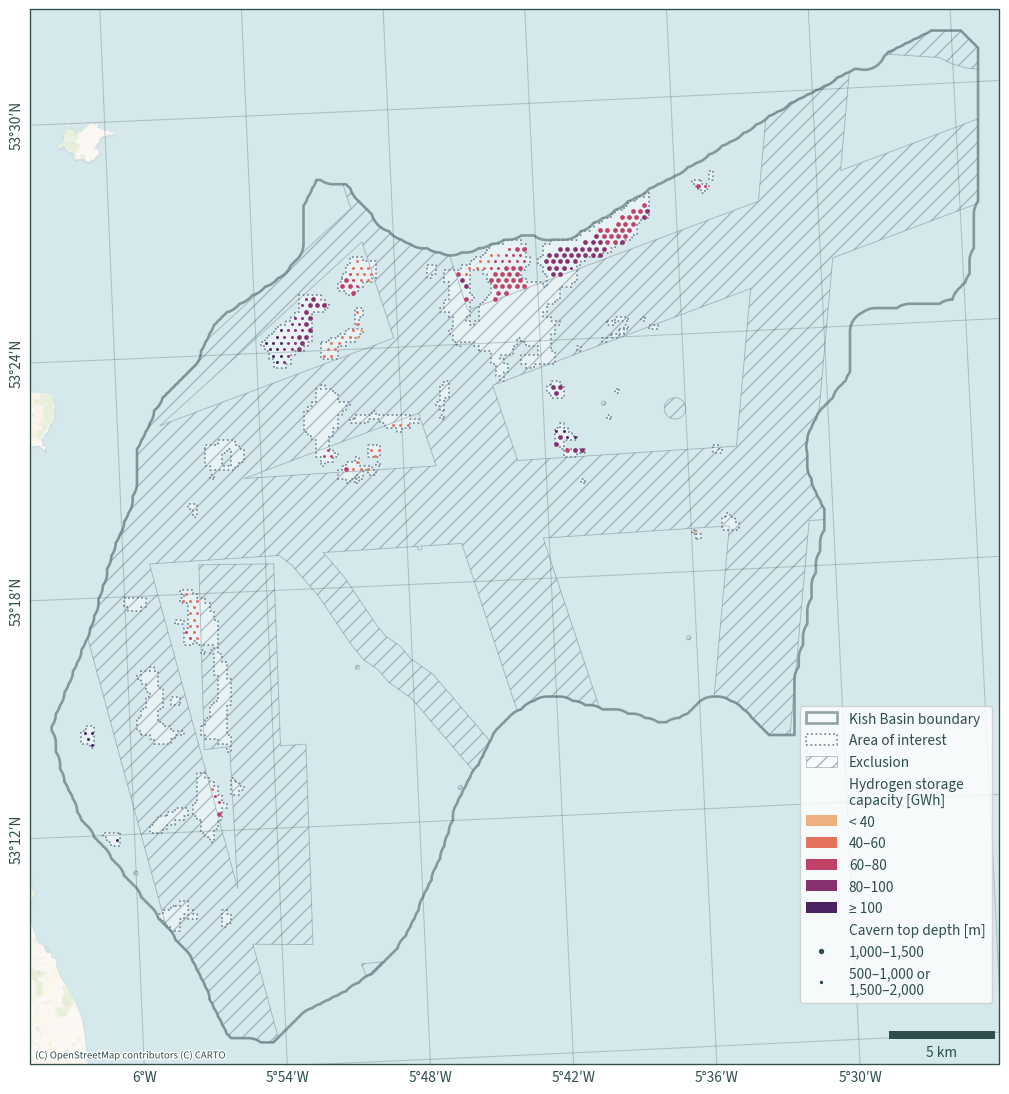

In [47]:
plot_map_alt(ds, caverns, zones, [0, 40, 60, 80, 100])

## Hystories cases

In [50]:
CAVERN_DIAMETER = 80
SEPARATION = 4 * CAVERN_DIAMETER
PILLAR_WIDTH = 3 * CAVERN_DIAMETER

In [51]:
# distance from salt formation edge
edge_buffer = fns.constraint_halite_edge(dat_xr=ds, buffer=PILLAR_WIDTH)

In [52]:
zones, zds = fns.zones_of_interest(
    dat_xr=ds, constraints={"net_height": 85, "min_depth": 500, "max_depth": 2000}
)

In [53]:
caverns = fns.generate_caverns_hexagonal_grid(
    zones_df=zones,
    dat_extent=extent,
    diameter=CAVERN_DIAMETER,
    separation=SEPARATION,
)

In [54]:
caverns = fns.cavern_dataframe(
    dat_zone=zds,
    cavern_df=caverns,
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [55]:
# label caverns by depth, use a fixed height of 225 m
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[85, 155, 311],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [56]:
caverns, _ = fns.generate_caverns_with_constraints(
    cavern_df=caverns,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 1,093
------------------------------------------------------------
Excluding salt formation edges...


Number of potential caverns: 1,056
------------------------------------------------------------
Exclude shipping...
Number of potential caverns: 524
Caverns excluded: 50.38%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 444
Caverns excluded: 57.95%
------------------------------------------------------------
Exclude cables...
Number of potential caverns: 444
Caverns excluded: 57.95%
------------------------------------------------------------
Exclude wells...
Number of potential caverns: 444
Caverns excluded: 57.95%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 444
Caverns excluded: 57.95%
------------------------------------------------------------


In [57]:
caverns["cavern_total_volume"] = cap.cavern_volume(
    height=caverns["cavern_height"], diameter=CAVERN_DIAMETER
)
caverns["cavern_volume"] = cap.corrected_cavern_volume(
    v_cavern=caverns["cavern_total_volume"],
)

In [58]:
caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

In [59]:
(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(thickness_overburden=caverns["TopDepthSeabed"], depth_water=-caverns["Bathymetry"])

In [60]:
caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

In [61]:
(
    caverns["working_mass"],
    caverns["mass_operating_min"],
    caverns["mass_operating_max"],
) = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

In [62]:
caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

In [63]:
# proportion of working gas to total gas
caverns["working_mass_pct"] = caverns["working_mass"] / (
    caverns["working_mass"] + caverns["mass_operating_min"]
)

In [64]:
caverns.drop(columns=["x", "y", "BaseDepth", "TopDepth", "TopTWT", "BaseDepthSeabed"]).describe()

,Thickness,TopDepthSeabed,Bathymetry,NetToGross,ThicknessNet,cavern_height,cavern_depth,cavern_total_volume,cavern_volume,t_mid_point,p_operating_min,p_operating_max,rho_min,rho_max,working_mass,mass_operating_min,mass_operating_max,capacity,working_mass_pct
count,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,4.440000e+02,444.000000,444.000000,4.440000e+02,4.440000e+02,444.000000,444.000000,4.440000e+02,4.440000e+02,4.440000e+02,444.000000,444.000000
mean,390.247481,1055.072904,-47.939072,0.620079,244.905232,117.495495,1135.072904,4.930227e+05,236154.175548,327.918274,7.920815e+06,2.112217e+07,5.516930,13.649268,1.951583e+06,1.325391e+06,3.276974e+06,65.031093,0.597983
std,62.478951,383.029759,13.447515,0.048620,61.527707,51.517009,383.029759,2.589527e+05,124036.416590,14.501092,2.704534e+06,7.212091e+06,1.577834,3.640004,1.166512e+06,8.090402e+05,1.974932e+06,38.870788,0.008179
min,316.430200,421.304826,-76.084564,0.554431,175.438574,85.000000,501.304826,3.296825e+05,157915.456354,303.542681,3.425755e+06,9.135347e+06,2.682620,6.922279,6.695076e+05,4.236272e+05,1.093135e+06,22.309482,0.581056
25%,347.018100,724.993635,-60.179893,0.582730,202.217816,85.000000,804.993635,3.296825e+05,157915.456354,315.533724,5.544648e+06,1.478573e+07,4.138643,10.482014,1.113892e+06,7.348075e+05,1.848700e+06,37.117366,0.592025
50%,372.943850,1021.792391,-43.723135,0.606716,226.270863,85.000000,1101.792391,3.296825e+05,157915.456354,326.908300,7.690944e+06,2.050918e+07,5.455870,13.583412,1.495739e+06,1.021467e+06,2.520163e+06,49.841335,0.598335
75%,414.259425,1319.926710,-41.460000,0.644940,267.172400,155.000000,1399.926710,6.815409e+05,326452.980096,337.549733,9.783794e+06,2.609012e+07,6.668764,16.345993,2.661945e+06,1.787590e+06,4.449535e+06,88.701928,0.605167
max,754.985800,1919.031682,-18.814272,0.750000,566.239350,311.000000,1999.031682,1.465682e+06,702050.890150,359.707438,1.395195e+07,3.720520e+07,8.762547,20.915819,6.928358e+06,4.791756e+06,1.172011e+07,230.868301,0.612466


In [65]:
# totals
caverns[
    [
        "cavern_volume",
        "working_mass",
        "capacity",
        "mass_operating_min",
        "mass_operating_max",
    ]
].sum()

cavern_volume         1.048525e+08
working_mass          8.665030e+08
capacity              2.887381e+04
mass_operating_min    5.884735e+08
mass_operating_max    1.454976e+09
dtype: float64

In [66]:
# compare to Ireland's electricity demand in 2050 (Deane, 2021)
compare.electricity_demand_ie(caverns_df=caverns)

Energy capacity as a percentage of Ireland's electricity demand in 2050: 23.67–34.37%


In [70]:
# total capacity at various depth/height combinations
s = caverns.groupby(["depth", "cavern_height", "halite"], sort=False)[["capacity"]].sum()
s["%"] = s["capacity"] / caverns[["capacity"]].sum().iloc[0] * 100
s

capacity          %
depth         cavern_height halite                          
1,000 - 1,500 311.0         Rossall   2575.536458   8.919976
              155.0         Rossall   7132.846345  24.703520
              85.0          Rossall   4924.492083  17.055224
500 - 1,000   311.0         Rossall    813.461887   2.817301
              155.0         Rossall   1618.600523   5.605775
1,500 - 2,000 155.0         Rossall   3808.158147  13.188972
500 - 1,000   85.0          Rossall   1889.654701   6.544530
1,500 - 2,000 85.0          Rossall   1089.636290   3.773788
1,000 - 1,500 85.0          Preesall   167.147300   0.578889
500 - 1,000   155.0         Preesall   680.560900   2.357018
              85.0          Preesall   795.717683   2.755846
1,500 - 2,000 85.0          Preesall   851.405553   2.948713
1,000 - 1,500 155.0         Fylde      296.036361   1.025277
              85.0          Fylde      506.517227   1.754245
1,500 - 2,000 155.0         Fylde      371.906974   1.288043
500 - 1,000   155.0         Fylde      129.074068   0.447028
              85.0          Fylde      975.657669   3.379041
1,500 - 2,000 85.0          Fylde      247.394984   0.856815

In [71]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",15602.575773
"1,500 - 2,000",6368.501948
"500 - 1,000",6902.727430


In [73]:
s.groupby("cavern_height").sum()[["capacity"]]

,capacity
cavern_height,
85.0,11447.623489
155.0,14037.183318
311.0,3388.998345


In [72]:
s.groupby("halite").sum()[["capacity"]]

,capacity
halite,
Fylde,2526.587283
Preesall,2494.831435
Rossall,23852.386433


In [74]:
# number of caverns
s = caverns.groupby(["depth", "cavern_height", "halite"], sort=False)[["capacity"]].count()
s["%"] = s["capacity"] / len(caverns) * 100
s

capacity          %
depth         cavern_height halite                       
1,000 - 1,500 311.0         Rossall         13   2.927928
              155.0         Rossall         73  16.441441
              85.0          Rossall        107  24.099099
500 - 1,000   311.0         Rossall          5   1.126126
              155.0         Rossall         25   5.630631
1,500 - 2,000 155.0         Rossall         32   7.207207
500 - 1,000   85.0          Rossall         64  14.414414
1,500 - 2,000 85.0          Rossall         18   4.054054
1,000 - 1,500 85.0          Preesall         4   0.900901
500 - 1,000   155.0         Preesall        10   2.252252
              85.0          Preesall        26   5.855856
1,500 - 2,000 85.0          Preesall        14   3.153153
1,000 - 1,500 155.0         Fylde            3   0.675676
              85.0          Fylde           11   2.477477
1,500 - 2,000 155.0         Fylde            3   0.675676
500 - 1,000   155.0         Fylde            2   0.450450
              85.0          Fylde           30   6.756757
1,500 - 2,000 85.0          Fylde            4   0.900901

In [75]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",211
"1,500 - 2,000",71
"500 - 1,000",162


In [76]:
s.groupby("cavern_height").sum()[["capacity"]]

,capacity
cavern_height,
85.0,278
155.0,148
311.0,18


In [77]:
s.groupby("halite").sum()[["capacity"]]

,capacity
halite,
Fylde,53
Preesall,54
Rossall,337


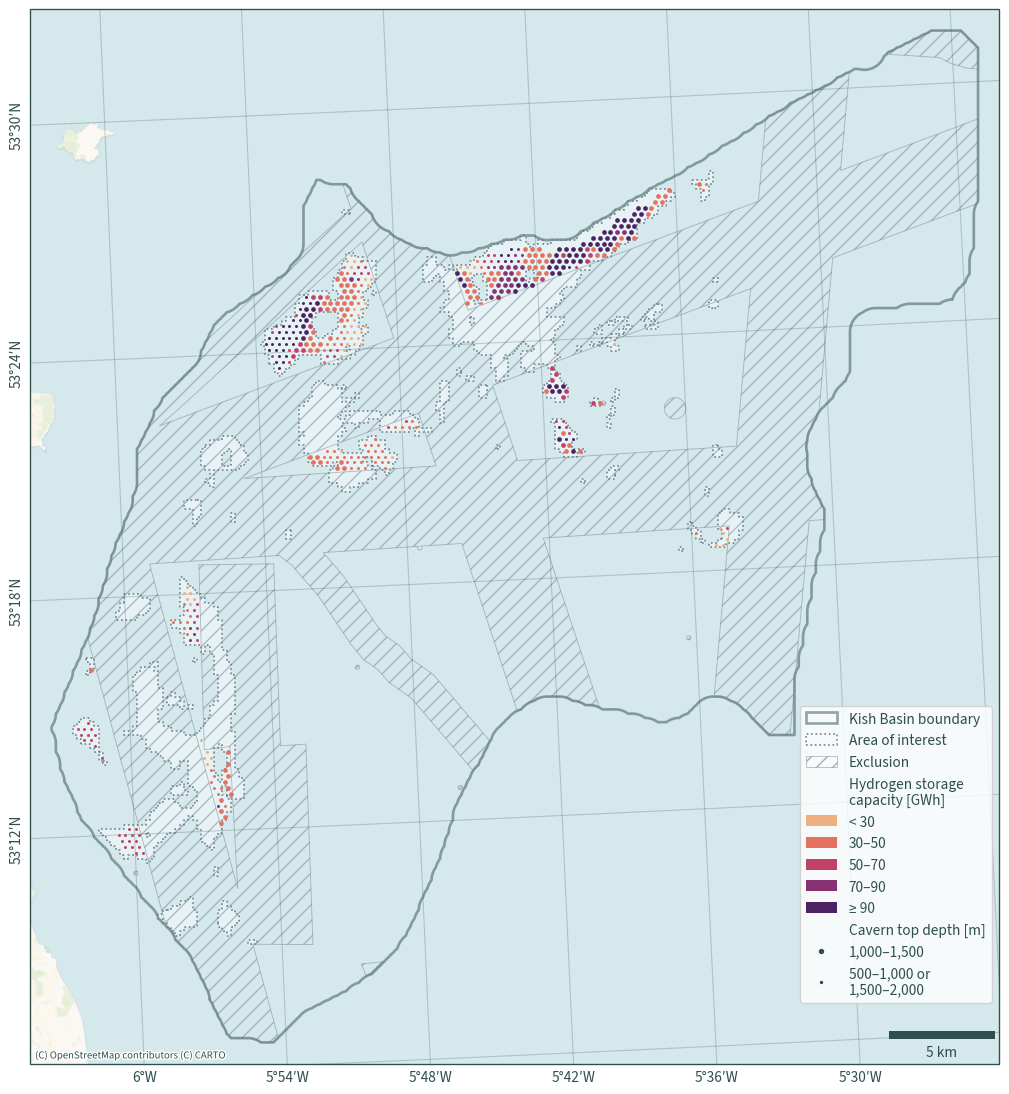

In [79]:
plot_map_alt(ds, caverns, zones, [0, 30, 50, 70, 90])

## Distribution

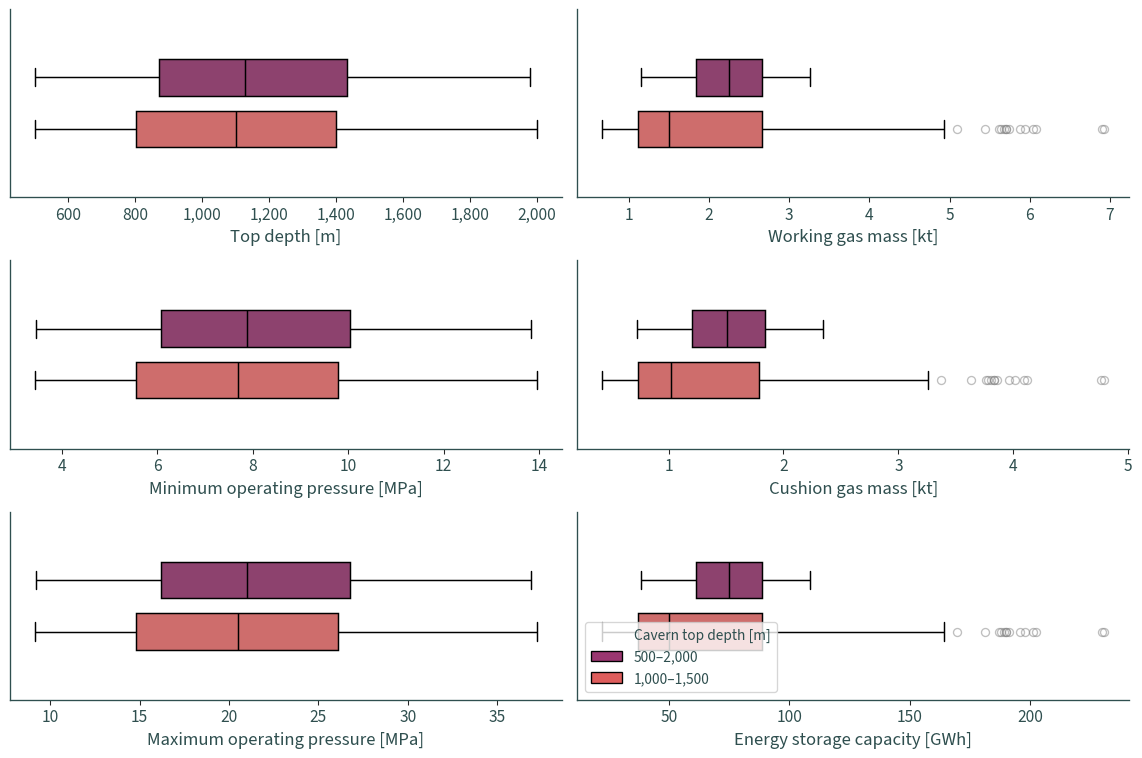

In [80]:
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
for variable, label, axis in zip(
    [
        "cavern_depth",
        "working_mass",
        "p_operating_min",
        "mass_operating_min",
        "p_operating_max",
        "capacity",
    ],
    [
        "Top depth [m]",
        "Working gas mass [kt]",
        "Minimum operating pressure [MPa]",
        "Cushion gas mass [kt]",
        "Maximum operating pressure [MPa]",
        "Energy storage capacity [GWh]",
    ],
    axes.flat,
):
    if variable in ["cavern_depth", "capacity"]:
        d1 = caverns_pot_all[[variable]]
        d2 = caverns[[variable]]
    else:
        d1 = caverns_pot_all[[variable]] / 1e6
        d2 = caverns[[variable]] / 1e6
    sns.boxplot(
        pd.concat(
            [d1.set_axis(["all"], axis=1), d2.set_axis(["optimal"], axis=1)]
        )
        .melt()
        .dropna(),
        x="value",
        hue="variable",
        palette="flare_r",
        linecolor="black",
        linewidth=1.1,
        gap=0.3,
        width=0.55,
        flierprops={"markeredgecolor": "grey", "alpha": 0.5},
        ax=axis,
        legend=False,
    )
    axis.set_xlabel(label)
    axis.tick_params(axis="y", left=False)
    if variable == "cavern_depth":
        axis.get_xaxis().set_major_formatter(
            ticker.FuncFormatter(lambda x, p: format(int(x), ","))
        )

legend_handles = [
    mpatches.Patch(label="Cavern top depth [m]", visible=False),
    mpatches.Patch(
        facecolor=sns.color_palette("flare_r", 2)[0],
        label="500–2,000",
        edgecolor="black",
    ),
    mpatches.Patch(
        facecolor=sns.color_palette("flare_r", 2)[1],
        label="1,000–1,500",
        edgecolor="black",
    ),
]
plt.legend(loc="lower left", handles=legend_handles, fontsize=11.5)
sns.despine()
plt.tight_layout()
plt.show()